<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/nlp_fundamental_in_tensor_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Funamentals in TensorFlow

NLP has the goal of derivin information out of natural language (could be text or speech).

Another common term for NLP problems is sequence to sequence problem (seq2seq)

In [76]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c2abe0ad-72e9-b835-49d6-a61d88fb51ef)


## Get helper function

In [77]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-29 02:02:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-29 02:02:43 (87.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [78]:
# Import a series of helper functions for teh notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, calculate_results

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

Se the orgin source here.

In [79]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2024-05-29 02:02:44--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.207, 173.194.217.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2024-05-29 02:02:44 (133 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [80]:
unzip_data("nlp_getting_started.zip")

## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python Pandas.

In [81]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [82]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [83]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [84]:
# ow many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [85]:
# How many total samples?

len(train_df), len(test_df)

(7613, 3263)

In [86]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [87]:
# Let's viaulaize some random training examples

import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("example\ temp")

Target: 1 (real disaster)
Text:
@BradleyBrad47 yeah but being fast and doing extremely high damage is what its all about if you want fast then im gonna have to get u the-

example\ temp
Target: 0 (not real disaster)
Text:
@BradleyBrad47 the saw is fast af and does great damage i upgraded it a shitton and used it exclusively for a whole playthrough

example\ temp
Target: 0 (not real disaster)
Text:
Let's say a tree falls on your fence. Do you know how your homeowners insurance may help? http://t.co/VLaIuvToMM http://t.co/AJpnEBG803

example\ temp
Target: 1 (real disaster)
Text:
@JoeDawg42 TOR for a TOR situation only. Wind damage enhanced wording is key IMO

example\ temp
Target: 1 (real disaster)
Text:
@HfxStanfield @beelieveDC @DiscoveryCntr what is happening we hear there is runway lighting damage by a contractor.

example\ temp


### Split dat into trainig and validation datasets

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
# Use train_test_split to split training dat into training and validation sets

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [90]:
# Check the lengths

len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [91]:
len(train_df_shuffled)

7613

In [92]:
# Check the firt 10 sentences

train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build the model is to convert your txt to numbers.

The a few ways to do this, namely:

* Tokeninzation - direct mapping of token (a token could be a word or a character) to number

* Embeding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embeding can be learned)


### Text vectorization (tokenization)

In [93]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [94]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [95]:
# Use the default TextVectorization parameters

text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <oov>)
                                    standardize="lower_and_strip_punctuation", # how to handle punctuation
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # creat a group of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be, if None, it will adjust automatically
                                    pad_to_max_tokens=False) # pad sequences to the same length


In [96]:
# Find the average number of tokens (words) in the trainig tweets

round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [97]:
# Steup text vectorization variables

max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a tweeot does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=max_length,
                                    output_mode="int"
                                    )

In [98]:
text_vectorizer.adapt(train_sentences)

In [99]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [100]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \n \nVectorized version:")

text_vectorizer([random_sentence])

Original text:
http://t.co/pWwpUm6RBj Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/ySpON4d6Qo 
 
Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 1053,  778,  111,    4,  934,  307,  324,  624,   85,    1,
           0,    0,    0,    0]])>

In [101]:
# Get the unique words in the vocabulary

words_in_vocab = text_vectorizer.get_vocabulary()

top_10_words = words_in_vocab[:10]

bottom_10_words = words_in_vocab[-10:]

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(top_10_words)
print(bottom_10_words)

Number of words in vocab: 10000
['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']
['painthey', 'painful', 'paine', 'paging', 'pageshi', 'pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating a Embedding using an Embedding layer

To make our embedding, we're going to use TensorFlow's embeding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for exampl, a value of 100 would mean each token gets represented by a vector 100 long.
* `input_length` = length of sequnces being passed to the embedding layer.

In [102]:
from tensorflow.keras.layers import Embedding

In [103]:
embedding = Embedding(input_dim=max_vocab_length, # set input shape
                      output_dim=128, # output shape
                      embeddings_initializer="uniform", # default, intialize randomly
                      input_length=max_length # how long is each input
                      )

In [104]:
embedding

In [106]:
# Get a random sentence from teh tarining set

random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \
    \n\nEmbedded version:")

# Embed the random sentence

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Headed to the massacre 
Bodies arriving everyday 
What were those shells you heard 
Picking the bones up along the way     

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-1.3618827e-02,  2.8883841e-02,  4.2363618e-02, ...,
         -1.2193609e-02, -2.0254366e-03, -1.6829371e-02],
        [-1.8328201e-02, -1.2017034e-02, -1.1251450e-02, ...,
          1.7082263e-02, -3.2914676e-02, -4.5737971e-02],
        [ 2.1959256e-02,  7.8450888e-05,  2.8438810e-02, ...,
         -4.0601693e-02,  4.1434232e-02,  3.8286518e-02],
        ...,
        [ 1.6352627e-02,  2.1423880e-02,  3.8068641e-02, ...,
          4.6285797e-02,  6.8589076e-03, -3.1560946e-02],
        [-3.2629155e-02,  3.2882515e-02,  1.1952080e-02, ...,
         -2.1337902e-02, -6.5612681e-03, -1.3026558e-02],
        [ 2.1959256e-02,  7.8450888e-05,  2.8438810e-02, ...,
         -4.0601693e-02,  4.1434232e-02,  3.8286518e-02]]], dtype=float32)>

In [107]:
# Check out a single sample token's embedding

sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01361883,  0.02888384,  0.04236362, -0.02716749, -0.03544551,
         0.0475336 , -0.03306536, -0.02853932,  0.01864705, -0.00676416,
         0.00916545,  0.00162537,  0.02081576,  0.01821952,  0.02795757,
        -0.0073079 , -0.02157643, -0.02246878,  0.00089073,  0.04421787,
        -0.03611358, -0.01380471, -0.02829217, -0.02098751, -0.04708683,
         0.02789343, -0.00355214, -0.0191987 ,  0.03274301,  0.01205171,
        -0.03018424,  0.0114547 ,  0.02116997, -0.03137403,  0.04969444,
         0.01221985, -0.01929761,  0.02894218,  0.00608126,  0.02222743,
        -0.02746744,  0.01181612,  0.01379165, -0.00079546, -0.04331291,
        -0.04377609,  0.04566151, -0.01581448,  0.04925383,  0.04321874,
        -0.04494561,  0.01025556,  0.04316692,  0.01688622, -0.01354814,
         0.01877889,  0.01943046, -0.04689553,  0.01876572,  0.04633436,
        -0.04276999,  0.00591043,  0.01582206, -0.04920023,  0.00399511,
  

## Modelling a text datset (running a series of experiments)

Now we've got a way to turn our text sequnces into numbers it's time to strat building series of modelling experitments.

[Machine learnign map](https://scikit-learn.org/0.18/tutorial/machine_learning_map/index.html#)

### Model 0: Geting a baseline

As with all machine learning models, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑 **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.'

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# Create tokenization and modeling ppeline

In [113]:
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # mdoel the text
                  ])

In [114]:
# Fite the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [115]:
# Evaluate our baseline model

baseline_score =  model_0.score(val_sentences, val_labels)

In [ ]:
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [116]:
# Make predictions

baseline_preds = model_0.predict(val_sentences)

baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [117]:
train_labels[:20]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0])

### Cerating a evaluation funtcion for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function.

Let's create a function to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

In [118]:
# Function to evaluate accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [119]:
# Get baseline results

baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [120]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Model 1: A simple Feed-forward neural network

In [121]:
# Create a tensorboard callback

SAVE_DIR = 'model_logs'

In [122]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [123]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [125]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [126]:
model_1_history = model_1.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_1_dense")]
    )

Saving TensorBoard log files to: model_logs/model_1_dense/20240529-020439
Epoch 1/5
215/215 [==============================] - 9s 37ms/step - loss: 0.6129 - accuracy: 0.6876 - val_loss: 0.5362 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 7s 33ms/step - loss: 0.4428 - accuracy: 0.8180 - val_loss: 0.4681 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3477 - accuracy: 0.8606 - val_loss: 0.4582 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2849 - accuracy: 0.8883 - val_loss: 0.4621 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.2381 - accuracy: 0.9129 - val_loss: 0.4810 - val_accuracy: 0.7861


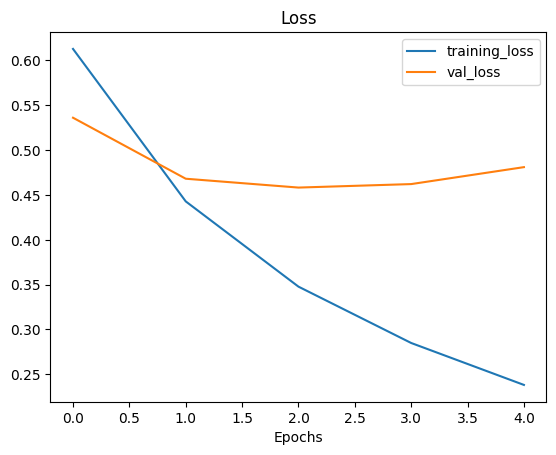

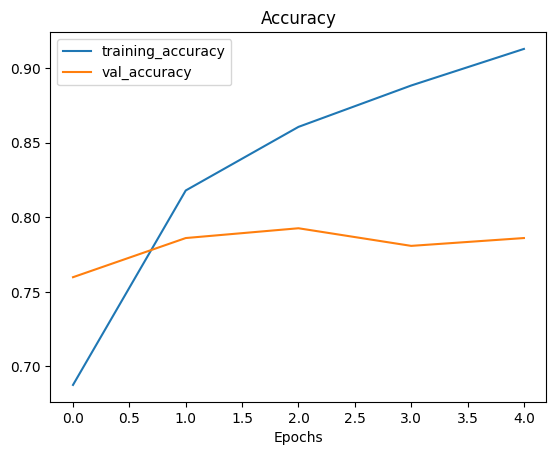

In [127]:
plot_loss_curves(model_1_history)

In [128]:
# check the results

model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 6ms/step - loss: 0.4810 - accuracy: 0.7861


[0.4810398519039154, 0.7860892415046692]

In [129]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:20]

24/24 [==============================] - 0s 2ms/step


array([[0.32351243],
       [0.8209758 ],
       [0.9980615 ],
       [0.11465962],
       [0.10456911],
       [0.93402547],
       [0.9170129 ],
       [0.99343526],
       [0.9605936 ],
       [0.2592594 ],
       [0.10608237],
       [0.6926294 ],
       [0.04631612],
       [0.13347518],
       [0.00507421],
       [0.12009414],
       [0.02861731],
       [0.07551999],
       [0.2092994 ],
       [0.50703186]], dtype=float32)

In [137]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [138]:
# Convert model prerdiciton to label format
for pred in model_1_preds[:20]:
  if pred > 0.5:
    print("Positive")
  else:
    print("Negative")

Negative
Positive
Positive
Negative
Negative
Positive
Positive
Positive
Positive
Negative
Negative
Positive
Negative
Negative
Negative
Negative
Negative
Negative
Negative
Positive


## Visualising learned embedding

In [139]:
# Get teh vocanulary from the text vectorization layer

words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [140]:
max_vocab_length

10000

In [141]:
# Model 1 summary

model_1.summary()


Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [145]:
# Get the weight matrix of embedding layer

# (the se are teh numeriacal representation of each token in our training data)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has an incredible tool called projector: https://projector.tensorflow.org/

And Tensorflow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/tutorials/text/word_embeddings

In [146]:
embed_weights

array([[-0.00083489, -0.01843508, -0.00069531, ...,  0.04391568,
         0.0293634 ,  0.01137651],
       [ 0.04724422, -0.03755752, -0.03346347, ...,  0.01573676,
        -0.03168109, -0.02353165],
       [ 0.03526462, -0.01062763,  0.02007761, ..., -0.03147613,
         0.03377579,  0.05065405],
       ...,
       [ 0.0039402 ,  0.04325724, -0.01731244, ...,  0.03193529,
        -0.03860478,  0.00552503],
       [ 0.00122097, -0.02790222, -0.01507414, ...,  0.08238478,
         0.0053055 ,  0.02455811],
       [-0.07208993, -0.0220221 , -0.05900475, ...,  0.08447503,
        -0.07640667,  0.04957233]], dtype=float32)

In [147]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\temp")
  out_m.write(word + "\temp")
out_v.close()
out_m.close()


## Recurrent Neural Networks (RNN's)


RNN's ae useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

if you want an overview of the internals of a rcurrent neural network, see the following:

- Andrej Karpathy's intro to RNN's: http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- Chris Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### Model 2: LSTM

LSTM = Long Shot Term Memory (one of the most poluplar LSTM cells)


Our structure of RNN typically looks like this:

```
  Input (text) -> Tokeninze -> Embedding -> Layer (RNN/dense) -> Output (label probability)
```

In [148]:
# Create a LSTM model

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)

(None, 15, 128)


In [149]:
x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
x = layers.LSTM(units=64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_6 (LSTM)               (None, 15, 64)            49408     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                      

In [150]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [151]:
model_2_history = model_2.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_LSTM")]
    )

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240529-020648
Epoch 1/5
215/215 [==============================] - 15s 50ms/step - loss: 0.2255 - accuracy: 0.9203 - val_loss: 0.6086 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1608 - accuracy: 0.9400 - val_loss: 0.6479 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1291 - accuracy: 0.9523 - val_loss: 0.7120 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1066 - accuracy: 0.9590 - val_loss: 0.8323 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0840 - accuracy: 0.9660 - val_loss: 1.2712 - val_accuracy: 0.7730


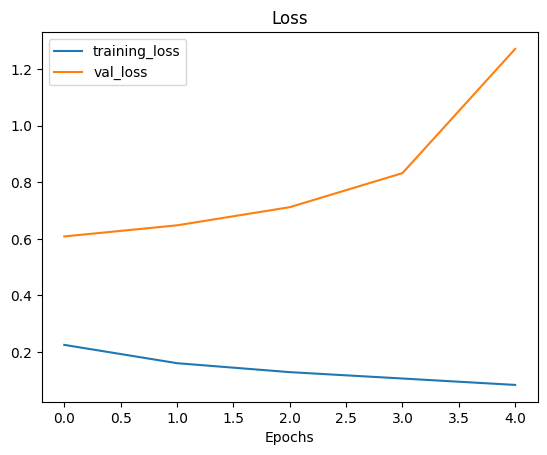

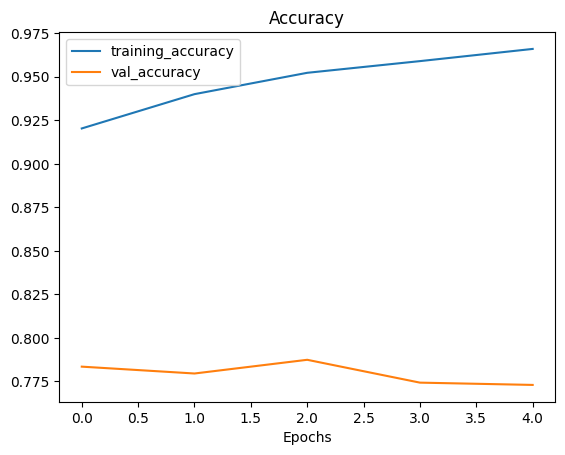

In [152]:
plot_loss_curves(model_2_history)

In [153]:
model_2.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 1.2712 - accuracy: 0.7730


[1.2712234258651733, 0.7729659080505371]

In [154]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:20]

24/24 [==============================] - 2s 6ms/step


array([[1.0603630e-02],
       [6.2762618e-01],
       [9.9997139e-01],
       [4.9456153e-03],
       [4.4707071e-05],
       [9.9989581e-01],
       [9.3276846e-01],
       [9.9998510e-01],
       [9.9996746e-01],
       [8.0644435e-01],
       [1.4239002e-04],
       [9.9525118e-01],
       [5.0544168e-05],
       [2.9551113e-02],
       [2.0159374e-05],
       [2.3643789e-03],
       [1.7697448e-04],
       [1.2731396e-04],
       [1.7948223e-02],
       [9.9971789e-01]], dtype=float32)

In [155]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

model_2_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [156]:
val_labels[:20]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [157]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)

In [158]:
model_2_results

{'accuracy': 77.29658792650919,
 'precision': 0.7730528656214299,
 'recall': 0.7729658792650919,
 'f1': 0.7718716556605149}

In [159]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

Another popular effective RNN comonent is the GR ou gated recurrent unit.

The GRU cell has similar fetures to an LSTM cel but has less parameters.

In [188]:
# Builsd a RNN using the GRU cell

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you meed return_sequences= True
x = layers.GRU(64)(x)
#x = layers.LSTM(42, return_sequences=True)(x)
#x = layers.GRU(99)(x)
#x = layers.GlobalAveragePooling1D()(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [189]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_16 (GRU)                (None, 15, 64)            37248     
                                                                 
 gru_17 (GRU)                (None, 64)                24960     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                       

In [190]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [191]:
model_3_history = model_3.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_GRU")]
    )


Saving TensorBoard log files to: model_logs/model_3_GRU/20240529-023912
Epoch 1/5
215/215 [==============================] - 17s 49ms/step - loss: 0.1106 - accuracy: 0.9561 - val_loss: 1.0279 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0484 - accuracy: 0.9780 - val_loss: 1.1929 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0361 - accuracy: 0.9804 - val_loss: 1.8056 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0442 - accuracy: 0.9804 - val_loss: 1.4674 - val_accuracy: 0.7402
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0430 - accuracy: 0.9809 - val_loss: 1.4582 - val_accuracy: 0.7546


In [192]:
model_3.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 1.4582 - accuracy: 0.7546


[1.4581763744354248, 0.7545931935310364]

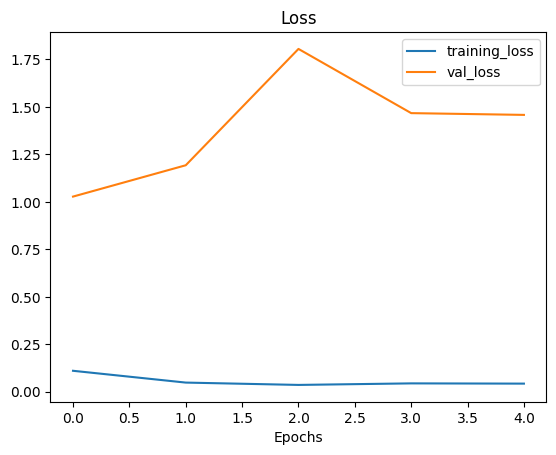

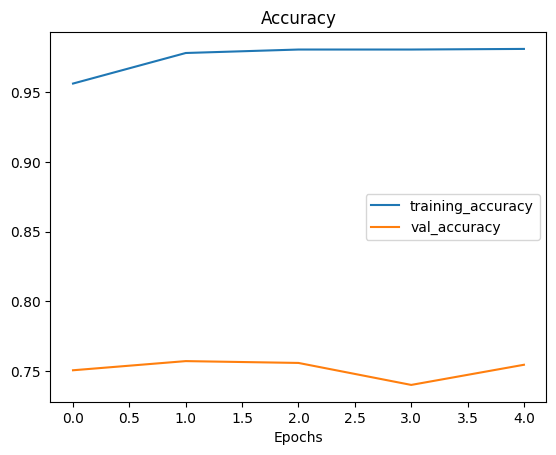

In [193]:
plot_loss_curves(model_3_history)

In [194]:
model_3_preds = tf.squeeze(tf.round(model_3.predict(val_sentences)))
model_3_preds[:20]

24/24 [==============================] - 2s 6ms/step


<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [195]:
for pred in model_3_preds[:20]:
  if pred > 0.5:
    print("Positive")
  else:
    print("Negative")

Negative
Negative
Positive
Negative
Negative
Positive
Positive
Positive
Positive
Negative
Negative
Positive
Negative
Negative
Negative
Negative
Negative
Negative
Negative
Positive


In [196]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 75.45931758530183,
 'precision': 0.7552799761217521,
 'recall': 0.7545931758530183,
 'f1': 0.7527017331356143}

### Model 4: Bidirecional RNN

Normal RNN's go from left to right (just like you 'd read an English sentence) however, a bidirecional RNN goes from right to left as well left to right.

In [213]:
# Build a bidirecional RNN  in TensorFlow

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) #

x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")


In [214]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [215]:
model_4_history = model_4.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_Bidirectional")]
    )

Saving TensorBoard log files to: model_logs/model_4_Bidirectional/20240529-030007
Epoch 1/5
215/215 [==============================] - 20s 53ms/step - loss: 0.0696 - accuracy: 0.9758 - val_loss: 1.7102 - val_accuracy: 0.7362
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0380 - accuracy: 0.9818 - val_loss: 1.3944 - val_accuracy: 0.7533
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0335 - accuracy: 0.9829 - val_loss: 1.5491 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0364 - accuracy: 0.9835 - val_loss: 1.5960 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0308 - accuracy: 0.9847 - val_loss: 1.7083 - val_accuracy: 0.7402


In [201]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                             

In [202]:
model_4.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 10ms/step - loss: 1.5837 - accuracy: 0.7585


[1.5836535692214966, 0.7585301995277405]

In [203]:
model_4_preds = tf.squeeze(tf.round(model_4.predict(val_sentences)))
model_4_preds[:20]

24/24 [==============================] - 5s 8ms/step


<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [204]:
for pred in model_4_preds[:20]:
  if pred > 0.5:
    print("Positive")
  else:
    print("Negative")

Negative
Positive
Positive
Negative
Negative
Positive
Positive
Positive
Positive
Negative
Negative
Positive
Negative
Negative
Negative
Negative
Negative
Negative
Negative
Positive


In [207]:
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)

model_4_results

{'accuracy': 75.8530183727034,
 'precision': 0.7585993128505528,
 'recall': 0.7585301837270341,
 'f1': 0.7572040956354258}